<h1>Chapter 8 - Semantic Search and Retrieval-Augmented Generation</h1>
<h1>第八章-语义搜索与检索增强生成  
    
<i>Exploring a vital part of LLMs, search.</i>

This notebook is for Chapter 8 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>


### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [2]:
%%capture
!pip install langchain==0.2.5 faiss-gpu==1.7.2 cohere==5.5.8 langchain-community==0.2.5 rank_bm25==0.2.2 sentence-transformers==3.0.1
!CMAKE_ARGS="-DLLAMA_CUDA=on" pip install llama-cpp-python==0.2.78

### Overview of Semantic Search and RAG
### 语义搜索和RAG概述

有很多研究是关于如何最好地使用语言模型进行搜索的。
这些模型可以分为三个广泛的类别：密集检索、重排序和RAG。
以下是这三个类别的概述，本章的其余部分将详细解释这些内容：

## 1.密集检索（Dense Retrieval）

密集检索系统依赖于嵌入（embeddings）的概念，这是我们在前几章中遇到的相同概念，并将搜索问题转化为检索搜索查询的最近邻居（在查询和文档都被转换为嵌入之后）。
图8-1展示了密集检索如何接收一个搜索查询，查阅其文本档案，并输出一组相关结果。

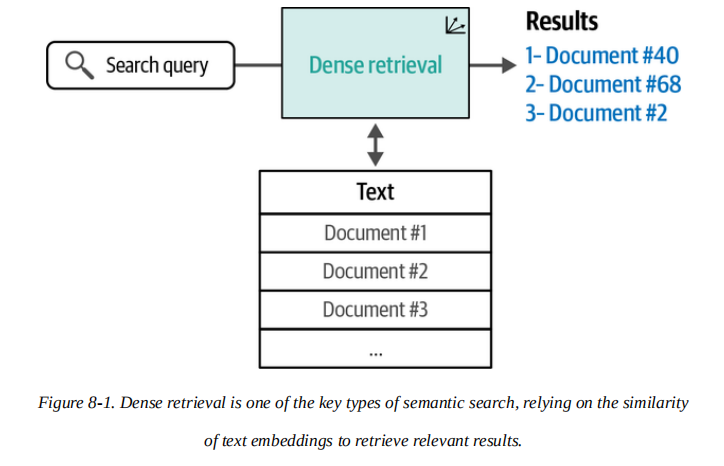

图8-1。密集检索是语义搜索的关键类型之一，它依赖于文本嵌入的相似性来检索相关结果。

## 2.重排序

搜索系统通常是多个步骤的管道。重排序语言模型是这些步骤之一，其任务是针对查询对结果子集的相关性进行评分；然后根据这些评分改变结果的顺序。图8-2展示了重排序器与密集检索的不同之处，它们接收一个额外的输入：来自搜索管道前一步骤的一组搜索结果。

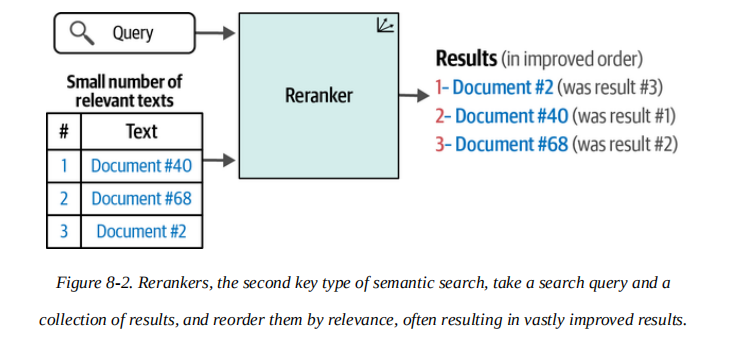

图8-2。重排序器，语义搜索的第二种关键类型，接收一个搜索查询和一组结果，并根据相关性重新排序它们，通常能够显著改善搜索结果。

## 3.RAG

大型语言模型（LLM）在文本生成方面的能力不断增强，导致了一种新型搜索系统的发展，这些系统包括一个模型，该模型能够针对查询生成答案。图8-3展示了这样一个生成性搜索系统的例子。 生成性搜索是更广泛的系统类别的一个子集，这些系统更好地被称为RAG系统。这些是文本生成系统，它们整合了搜索能力，以减少幻觉、增加事实性，和/或将生成模型基于特定数据集进行定位。

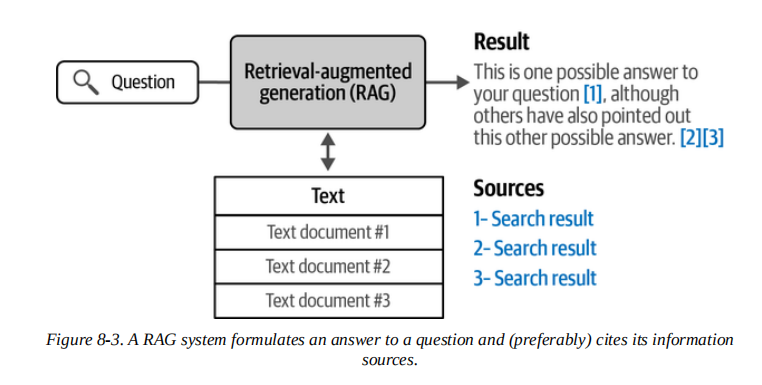

本章的其余部分将更详细地介绍这三种类型的系统。 虽然这些是主要的类别，但它们并不是搜索领域中唯一的大型语言模型（LLM）应用。

# 语言模型与语义搜索

现在让我们更深入地探讨可以提升我们语言模型搜索能力的系统的主要类别。我们将从密集检索开始，然后依次讨论重排序和RAG。

# Dense Retrieval Example


回想一下，嵌入（embeddings）是将文本转换为数值表示。这些可以被看作是空间中的点，正如我们在图8-4中看到的。彼此靠近的点意味着它们所代表的文本是相似的。因此，在这个例子中，文本1和文本2彼此更相似（因为它们彼此靠近），而文本3则不那么相似（因为它离得更远）。

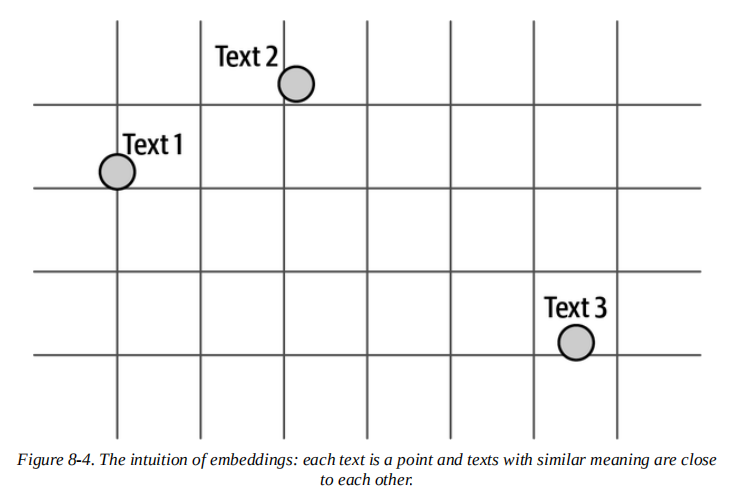

图8-4:嵌入的直觉：每篇文本是一个点，意义相似的文本彼此靠近

这是用来构建搜索系统的特性。在这种情况下，当用户输入一个搜索查询时，我们对查询进行嵌入，将其投影到与我们的文本档案相同的空间中。然后我们只需找到该空间中最接近查询的文档，那些就是搜索结果（见图8-5）。

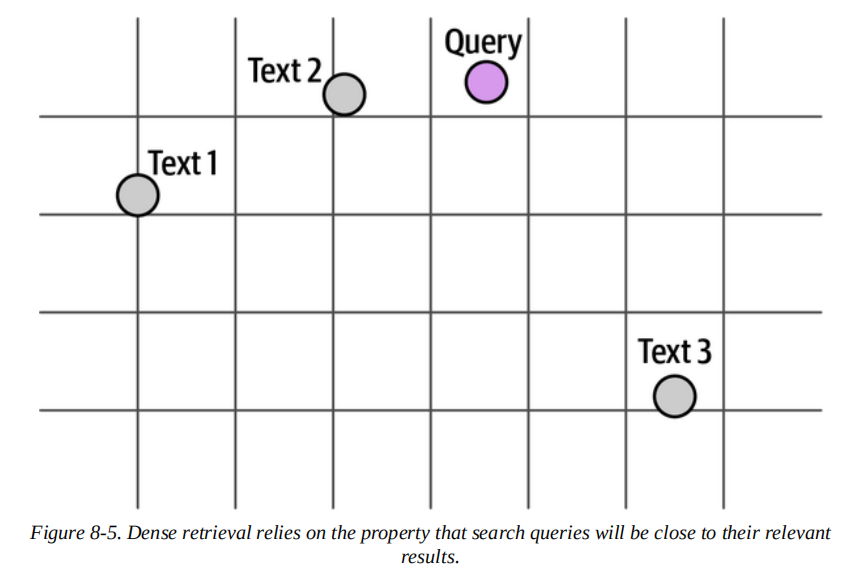

密集检索依赖于这样一个特性：搜索查询会接近它们相关的结果

根据图8-5中的距离判断，“文本2”是这个查询的最佳结果，其次是“文本1”。然而，这里可能会产生两个问题：  
应该返回“文本3”作为结果吗？这是一个由你，系统设计者来决定的问题。有时，设定一个最大相似度阈值来过滤掉不相关的结果可能是可取的（如果语料库中没有与查询相关的结果）。  
 查询和它的最佳结果在语义上是相似的吗？并不总是。这就是为什么语言模型需要在问题-答案对上进行训练，以提高检索能力。这个过程在第10章中有更详细的解释。  
图8-6展示了我们在嵌入每个部分之前如何对文档进行分块。这些嵌入向量随后存储在向量数据库中，随时准备用于检索。  

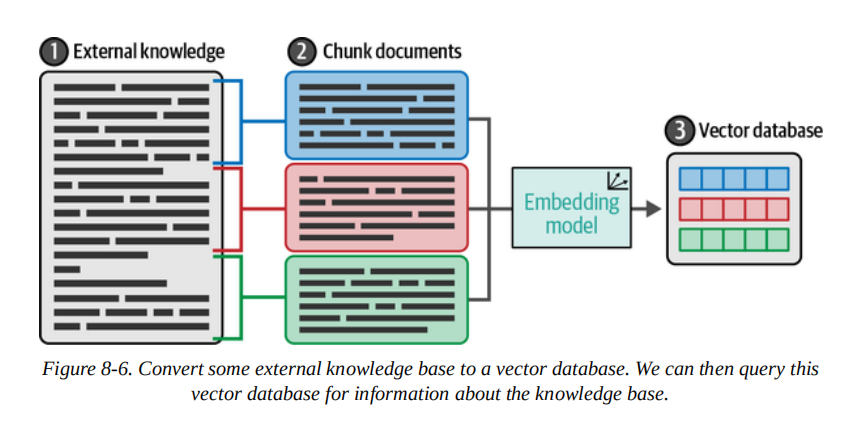

图8-6。将一些外部知识库转换为向量数据库。然后，我们就可以查询这个向量数据库以获取有关知识库的信息。

密集检索示例
让我们通过使用Cohere搜索电影《星际穿越》的维基百科页面来查看一个**密集检索**的例子。在这个例子中，我们将执行以下操作：  

1.获取我们想要使其可搜索的文本，并对其进行一些轻量级的处理，将其分块成句子。  
2.嵌入句子。  
3.构建搜索索引。  
4.搜索并查看结果。   

通过在[注册获取您的Cohere ](https://oreil.ly/GxrQ1)API密钥。将其粘贴在以下代码中。您不需要

支付任何费用即可完成这个示例。 让我们导入我们需要的库：


In [3]:
import cohere

# Paste your API key here. Remember to not share publicly
api_key = '8ZrfRQwRZFPe0D5Kcf6tmOB9KGop6mAhdbyUhArq'#在上面的网站中获取API！！！

# Create and retrieve a Cohere API key from os.cohere.ai 创建并从os.cohere.ai获取Cohere API密钥
co = cohere.Client(api_key)

## 1. Getting the text archive and chunking it
## 1. 获取文本档案并对其进行分块处理


获取文本档案并进行分块
让我们使用维基百科上关于电影《星际穿越》的第一段。 我们将获取文本，然后将其分解成句子：

In [4]:
text = """
Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan.
It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine.
Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind.

Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007.
Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar.
Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm.
Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles.
Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects.

Interstellar premiered on October 26, 2014, in Los Angeles.
In the United States, it was first released on film stock, expanding to venues using digital projectors.
The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014.
It received acclaim for its performances, direction, screenplay, musical score, visual effects, ambition, themes, and emotional weight.
It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics. Since its premiere, Interstellar gained a cult following,[5] and now is regarded by many sci-fi experts as one of the best science-fiction films of all time.
Interstellar was nominated for five awards at the 87th Academy Awards, winning Best Visual Effects, and received numerous other accolades"""

# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = [t.strip(' \n') for t in texts]
texts

['Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan',
 'It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine',
 'Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind',
 'Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007',
 'Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar',
 'Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm',
 'Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles',
 'Interstellar uses extensive practical a

## 2. Embedding the Text Chunks


好的，现在我们将嵌入这些文本。我们将它们发送到 Cohere API，并为每段文本获取一个向量。

In [5]:
import numpy as np

# Get the embeddings
response = co.embed(
  texts=texts,
  input_type="search_document",
).embeddings

embeds = np.array(response)
print(embeds.shape)

(15, 4096)


这个输出（15, 4096）表示我们有15个向量，每个向量的大小为4,096。

## 3. Building The Search Index


在我们能够进行搜索之前，我们需要构建一个搜索索引。索引存储嵌入向量，并针对快速检索最近邻进行了优化，即使我们有非常大的点数也是如此：

In [6]:
import faiss

dim = embeds.shape[1]
index = faiss.IndexFlatL2(dim)#IndexFlatL2是faiss中的一个索引类型，它使用L2距离（也称为欧几里得距离）来计算向量之间的相似度
np.float32(embeds)
index.add(np.float32(embeds))#将embeds数组的数据类型转换为32位浮点数加入索引中

## 4. Search the index


我们现在可以使用任何我们想要的查询来搜索数据集。我们只需嵌入查询并将其嵌入向量呈现给索引，索引将检索出维基百科文章中最相似的句子。
让我们定义我们的搜索函数：

In [7]:
import pandas as pd

def search(query, number_of_results=3):

  # 1. Get the query's embedding
  query_embed = co.embed(texts=[query],
                input_type="search_query",).embeddings[0]  #为每段文本获取一个向量

  # 2. Retrieve the nearest neighbors检索最近的邻居
  distances , similar_item_ids = index.search(np.float32([query_embed]), number_of_results)

  # 3. Format the results
  texts_np = np.array(texts) # Convert texts list to numpy for easier indexing将文本列表转换为numpy数组以便于索引
  results = pd.DataFrame(data={'texts': texts_np[similar_item_ids[0]],
                              'distance': distances[0]})
  # 4. Print and return the results
  print(f"Query:'{query}'\nNearest neighbors:")
  return results

In [8]:
query = "how precise was the science"
results = search(query)
results

Query:'how precise was the science'
Nearest neighbors:


texts      distance
0  It has also received praise from many astronom...  10757.379883
1  Caltech theoretical physicist and 2017 Nobel l...  11566.131836
2  Interstellar uses extensive practical and mini...  11922.833008

第一个结果具有最小的距离，因此与查询最为相似。观察它，它完美地回答了问题。请注意，如果我们仅进行关键词搜索，这是不可能实现的，因为顶部结果并未包含查询中的相同关键词。
实际上，我们可以通过定义一个关键词搜索函数来比较这两种方法。我们将使用**BM25算法**，这是领先的关键词搜索方法之一。有关这些代码片段的来源，请参阅这个笔记本：

In [9]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string

def bm25_tokenizer(text):#分词器
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

In [10]:
from tqdm import tqdm

tokenized_corpus = []
for passage in tqdm(texts):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

100%|██████████| 15/15 [00:00<00:00, 8379.67it/s]


In [11]:
def keyword_search(query, top_k=3, num_candidates=15):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]#-num_candidates 表示从得分数组的末尾开始选择，[-num_candidates:] 则获取这些索引对应的文档。
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f"Top-3 lexical search (BM25) hits")
    for hit in bm25_hits[0:top_k]:
        print("\t{:.3f}\t{}".format(hit['score'], texts[hit['corpus_id']].replace("\n", " ")))


现在，当我们使用相同的查询进行搜索时，从密集检索搜索中我们得到了一组不同的结果。

In [12]:
keyword_search(query = "how precise was the science")

Input question: how precise was the science
Top-3 lexical search (BM25) hits
	1.789	Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan
	1.373	Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar
	0.000	It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine


请注意，尽管第一个结果与查询共享了“science”这个词，但它并没有真正回答这个问题。在下一节中，我们将看到添加一个重排器（reranker）如何能够改进这个搜索系统。但在那之前，让我们通过查看其局限性并讨论一些将文本分解成块的方法来完成我们对密集检索的概述。

## Caveats of Dense Retrieval
## 密集搜索的局限性

了解密集检索的一些缺点及其应对方法是有用的。例如，如果文本中不包含答案会怎样？我们仍然会得到结果和它们之间的距离。例如：

In [13]:
query = "What is the mass of the moon?"
results = search(query)
results

Query:'What is the mass of the moon?'
Nearest neighbors:


texts      distance
0  Cinematographer Hoyte van Hoytema shot it on 3...  12854.458984
1  The film had a worldwide gross over $677 milli...  13301.030273
2  It has also received praise from many astronom...  13332.011719

在这种情况下，一种可能的启发式方法是设置一个阈值水平——例如，相关性的最远距离。许多搜索系统向用户提供他们能得到的最佳信息，并让用户自己决定是否相关。追踪用户是否点击了结果（以及是否满意）的信息可以改进搜索系统的未来版本。  

密集检索的另一个局限性是当用户想要找到特定短语的精确匹配时。这是关键词匹配的理想情况。这也是为什么建议使用混合搜索（包括语义搜索和关键词搜索），而不是完全依赖于密集检索。  
  
密集检索系统在它们训练之外的领域中也难以正常工作。例如，如果你在互联网和维基百科数据上训练一个检索模型，然后在法律文本上部署它（而没有足够的法律数据作为训练集的一部分），模型在法律领域的表现就不会那么好。  

最后我们想指出的是，这是一个每个句子都包含信息片段的情况，我们展示了特别询问这些信息的查询。那么那些答案跨越多个句子的问题呢？这突出了密集检索系统的一个重要设计参数：如何最好地将长文本分块？我们为什么首先需要将它们分块？  

### Chunking long texts
### 将长文本分块

Transformer语言模型的一个局限性是它们在上下文大小上有所限制，这意味着我们不能给它们输入超过模型支持的单词或标记数量的非常长的文本。那么，我们如何嵌入长文本呢？

有几种可能的方法，图8-7中展示的两种可能的方法包括：为每个文档索引一个向量和为每个文档索引多个向量。

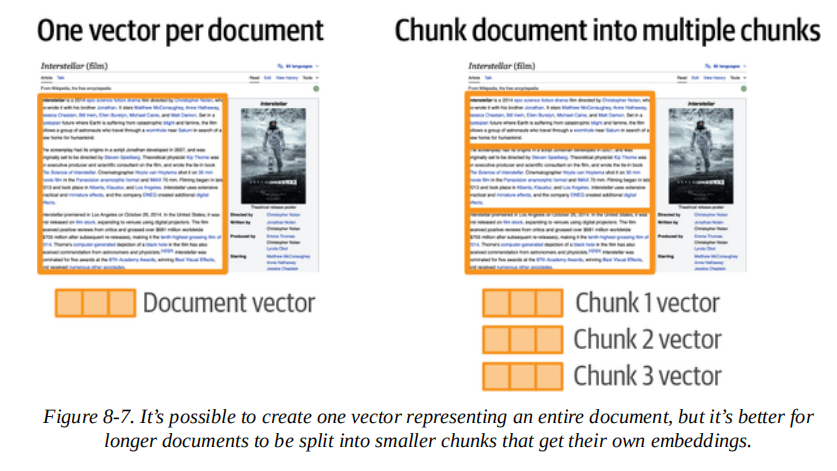


图8-7。可以创建一个向量来代表整个文档，但对于较长的文档来说，将其分割成更小的块，每个块都有自己的嵌入，会更好。

# 每个文档一个向量

在这种方法中，我们使用一个单一的向量来表示整个文档。这里的可能性包括：
  
1. 仅嵌入文档的代表性部分并忽略其余文本。这可能意味着仅嵌入标题，或者仅嵌入文档的开头部分。这对于快速开始构建演示很有用，但它使得很多信息没有被索引，因此无法搜索。作为一种方法，它可能更适合于开头就能捕捉到文档主要点的文档（比如：维基百科文章）。但它并不是一个真实系统的最佳方法，因为很多信息将被排除在索引之外，因此无法被搜索。  
2. 将文档分块嵌入，嵌入这些块，然后将这些块聚合成一个单一的向量。这里常用的聚合方法是对这些向量进行平均。这种方法的缺点是它会导致一个高度压缩的向量，丢失了文档中的很多信息。这种方法可以满足一些信息需求，但不能满足其他需求。很多时候，搜索是为了找到文章中包含的特定信息片段，如果这个概念有它自己的向量，那么它将被更好地捕捉。

# 每个文档多个向量

在这种方法中，我们将文档分割成更小的部分，并嵌入这些部分。我们的搜索索引随后变成了这些部分嵌入的索引，而不是整个文档的嵌入。图8-8展示了一些可能的文本分块方法。

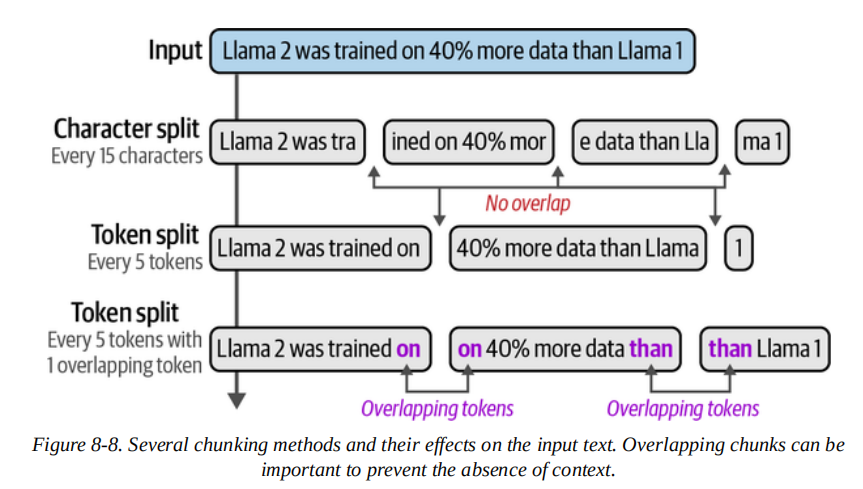

图8-8。几种分块方法及其对输入文本的影响。重叠的块很重要，可以防止上下文的缺失。

分块方法更好，因为它能够全面覆盖文本，并且向量倾向于捕捉文本中的个别概念。这导致了一个更具表现力的搜索索引。图8-9展示了一些可能的方法。

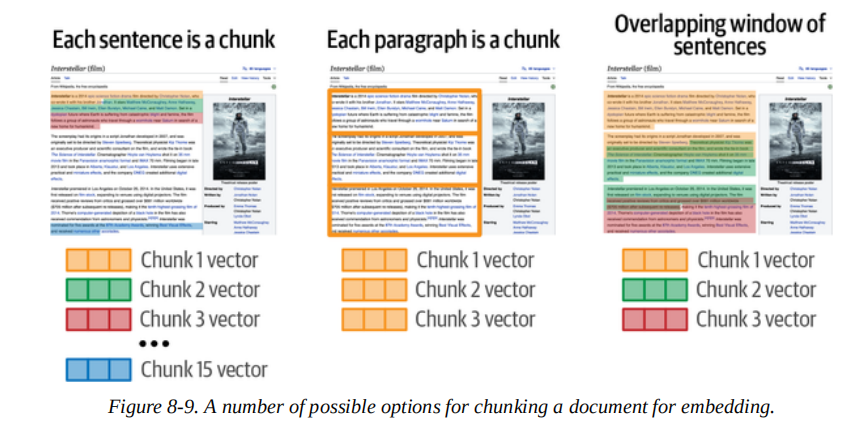

图8-9。将文档分块以进行嵌入的多种可能选项。

分块长文本的最佳方式将取决于你的系统预期处理的文本类型和查询。方法包括：
1. 每个句子作为一个块。这里的问题是这可能太过细粒度，向量无法捕捉足够的上下文。
2. 每个段落作为一个块。如果文本由短段落组成，这是很好的。否则，可能是每3-8个句子作为一个块。
3. 一些块的意义很大程度上来自于周围的文本。因此，我们可以通过以下方式加入一些上下文：
- 将文档的标题添加到块中。
- 将它们前后的一些文本添加到块中。这样，块可以重叠，以便它们包含也出现在相邻块中的周围文本。这就是我们在图8-10中可以看到的。   
随着领域的发展，预计会出现更多的分块策略——其中一些甚至可能使用大型语言模型（LLMs）动态地将文本分割成有意义的块。

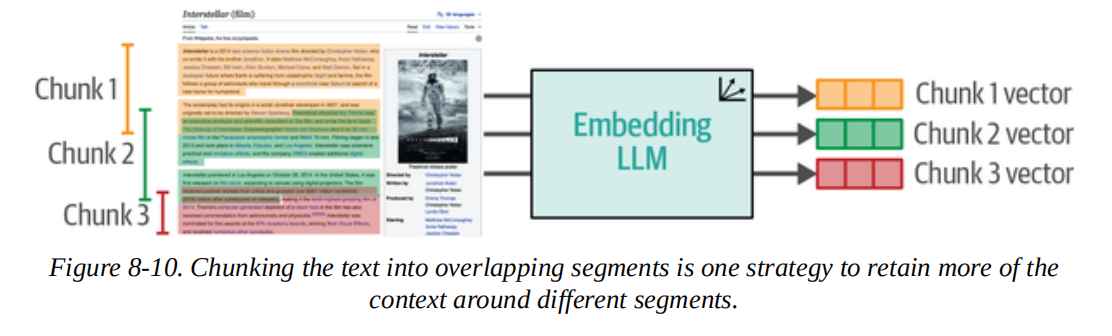

图8-10。将文本分块成重叠的段落是一种保留不同段落周围更多上下文的策略。

# 最近邻搜索与向量数据库的对比

一旦查询被嵌入，我们需要从我们的文本档案中找到最接近它的向量，如我们在图8-11中看到的。找到最近邻最直接的方法是计算查询和档案之间的距离。这可以很容易地用NumPy来完成，并且如果你的档案中有数千或数万个向量，这是一个合理的接近方法。

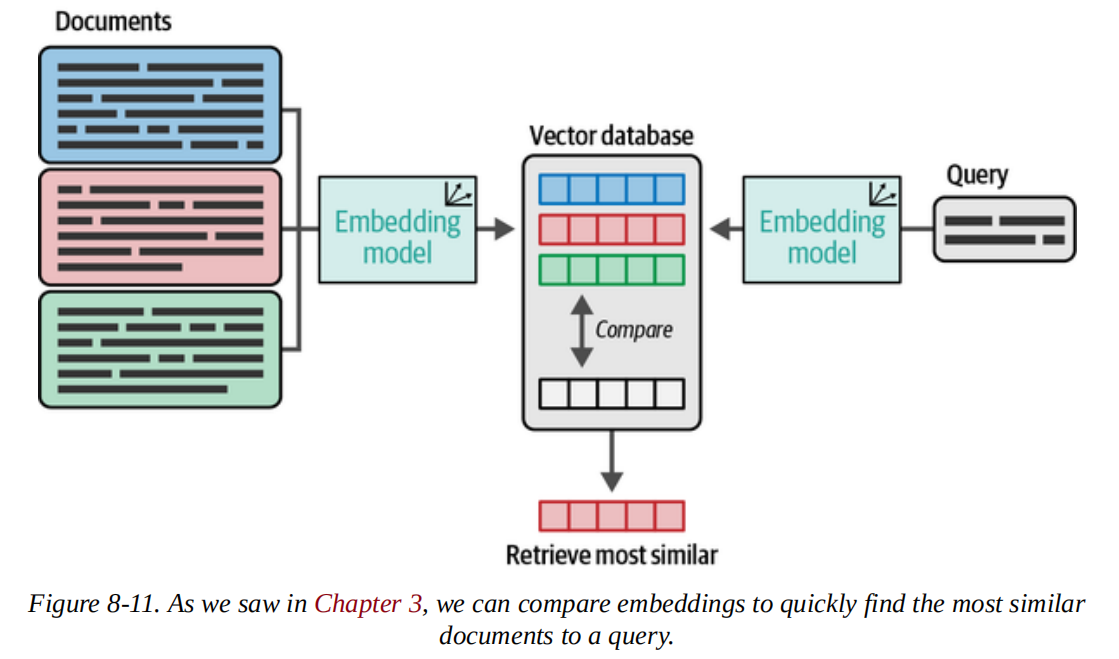

图8-11。正如我们在第3章看到的，我们可以比较嵌入向量以快速找到与查询最相似的文档。

当您扩展到数百万向量时，检索的优化方法是依赖于近似最近邻搜索库，如Annoy或FAISS。这些库允许您从庞大的索引中以毫秒为单位检索结果，其中一些可以通过利用GPU和扩展到机器集群来提高性能，以服务非常大的索引。

另一类向量检索系统是向量数据库，如Weaviate或Pinecone。向量数据库允许您添加或删除向量，而无需重建索引。它们还提供了过滤搜索或以超出仅向量距离的方式自定义搜索的方法。

# 为密集检索微调嵌入模型

正如我们在第4章关于文本分类的讨论中提到的，我们可以通过微调来提高大型语言模型（LLM）在特定任务上的性能。与那个案例一样，检索需要优化文本嵌入，而不仅仅是标记（token）嵌入。微调的过程是获取由查询和相关结果组成的训练数据。

让我们来看一个来自我们数据集的例子，句子是“《星际穿越》（Interstellar）于2014年10月26日在洛杉矶首映。” 两个可能的相关查询是：   
相关查询1：“《星际穿越》上映日期”    
相关查询2：“《星际穿越》何时首映”

微调的目标是使这些查询的嵌入接近结果句子的嵌入。同时，它还需要看到与句子不相关的查询的负例，例如：    
不相关查询：“《星际穿越》演员阵容”

有了这些例子，我们现在有三个配对——两个正配对和一个负配对。假设如我们在图8-12中看到的，微调前，所有三个查询与结果文档的距离相同。这是有可能的，因为它们都在谈论《星际穿越》。

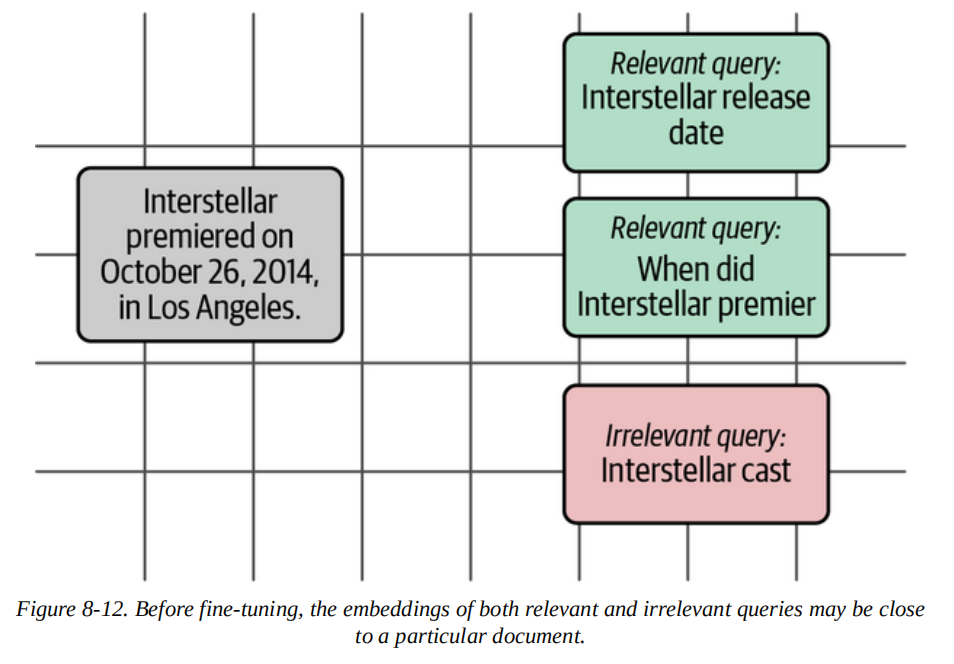

图8-12。在微调之前，相关和不相关的查询的嵌入可能都接近某个特定文档。

微调步骤旨在使相关查询更接近文档，同时使不相关查询更远离文档。我们可以在图8-13中看到这种效果。

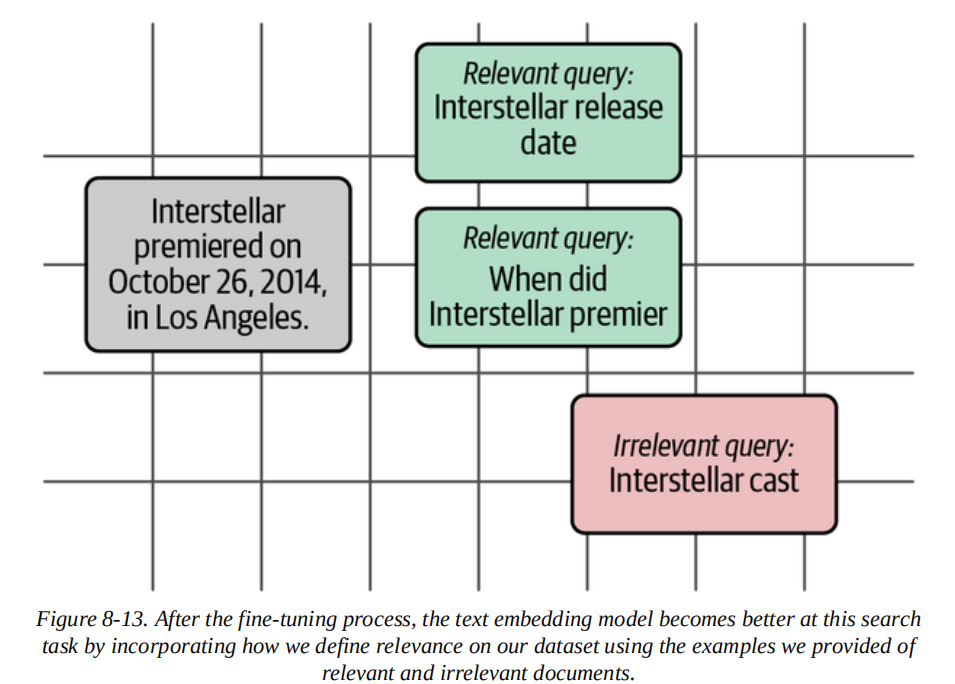

图8-13。在微调过程之后，文本嵌入模型通过结合我们如何使用提供的有关相关和不相关文档的例子来定义数据集中的相关性，从而在这个搜索任务中变得更擅长。

# Reranking


许多组织已经建立了搜索系统。对于那些组织来说，将语言模型作为一个更简单的方法融入他们的搜索流程中的最后一步是可行的。这一步的任务是根据与搜索查询的相关性改变搜索结果的顺序。这一步可以大幅改善搜索结果，实际上这就是微软Bing通过使用类似BERT的模型来改进搜索结果所添加的功能。

图8-14显示了一个重排搜索系统的结构，它作为两阶段搜索系统的第二阶段。

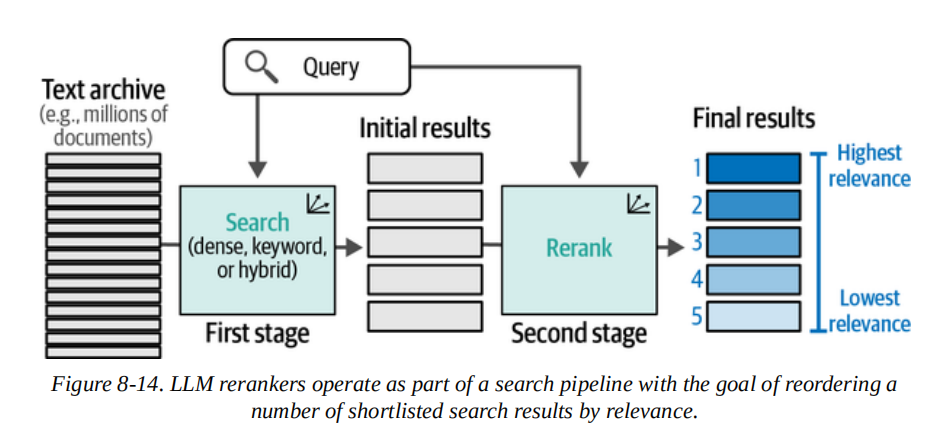

图8-14。大型语言模型（LLM）重排器作为搜索流程的一部分，目标是按相关性重新排序一系列入围的搜索结果。

# Reranking example

重排器接收搜索查询和一系列搜索结果，并返回这些文档的最优排序，使得与查询最相关的文档排名更高。Cohere的Rerank端点是开始使用第一个重排器的简单方式。我们只需将查询和文本传递给它，然后就能获得结果。我们不需要训练或调整它：

In [14]:
query = "how precise was the science"
results = co.rerank(query=query, documents=texts, top_n=3, return_documents=True)
results.results

[RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics'), index=12, relevance_score=0.16968088),
 RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014'), index=10, relevance_score=0.07004896),
 RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar'), index=4, relevance_score=0.0043994132)]

In [15]:
for idx, result in enumerate(results.results):
    print(idx, result.relevance_score , result.document.text)

0 0.16968088 It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics
1 0.07004896 The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014
2 0.0043994132 Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar


这表明重排器对第一个结果的把握要大得多，给它分配了一个相关性得分0.16，而其他结果的相关性得分则低得多。

在这个基本示例中，我们将所有15个文档传递给了我们的重排器。然而，通常情况下，我们的索引会有成千上万个条目，我们需要先筛选出，比如说一百个或一千个结果，然后将这些结果呈现给重排器。这个筛选步骤被称为搜索流程的第一阶段。

第一阶段的检索器可以是关键词搜索、密集检索，或者更好的是——结合两者的混合搜索。我们可以回顾我们之前的例子，看看在关键词搜索系统之后添加一个重排器是如何提高其性能的。

让我们调整我们的关键词搜索功能，使其使用关键词搜索检索出前10个结果，然后使用重排器从这10个结果中选择前3个结果：

In [16]:
def keyword_and_reranking_search(query, top_k=3, num_candidates=10):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f"Top-3 lexical search (BM25) hits")
    for hit in bm25_hits[0:top_k]:
        print("\t{:.3f}\t{}".format(hit['score'], texts[hit['corpus_id']].replace("\n", " ")))

    #Add re-ranking
    docs = [texts[hit['corpus_id']] for hit in bm25_hits]

    print(f"\nTop-3 hits by rank-API ({len(bm25_hits)} BM25 hits re-ranked)")
    results = co.rerank(query=query, documents=docs, top_n=top_k, return_documents=True)
    for hit in results.results:
        print("\t{:.3f}\t{}".format(hit.relevance_score, hit.document.text.replace("\n", " ")))

现在我们可以发送我们的查询，并检查关键词搜索的结果，然后是关键词搜索筛选出的前10个结果，然后将它们传递给重排器：

In [17]:
keyword_and_reranking_search(query = "how precise was the science")

Input question: how precise was the science
Top-3 lexical search (BM25) hits
	1.789	Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan
	1.373	Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar
	0.000	Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects

Top-3 hits by rank-API (10 BM25 hits re-ranked)
	0.004	Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar
	0.004	Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind
	0.003	Brothers Christopher and Jonat

我们可以看到关键词搜索只为两个共享一些关键词的结果分配了分数。在第二组结果中，重排器适当地提升了第二个结果，将其作为查询最相关的结果。这是一个简化的例子，让我们窥见了效果，但在实践中，这样的流程显著提高了搜索质量。在像MIRACL这样的多语言基准测试中，重排器可以将性能从36.5提高到62.8，以nDCG@10为衡量标准（本章稍后将详细介绍评估方法）。

# 使用句子转换器进行开源检索和重排

如果你想在自己的机器上本地设置检索和重排，你可以使用句子转换器（Sentence Transformers）库。参考 https://oreil.ly/jJOhV 上的文档进行设置。查看“检索与重排”部分，了解如何在该库中进行这些步骤的指导和代码示例。

句子转换器（又名双编码器）模型的特点：

1. 计算给定文本或图像的固定大小的向量表示（嵌入）。

2. 嵌入计算往往是高效的，嵌入相似度计算非常快。

3. 适用于广泛的任务，例如语义文本相似度、语义搜索、聚类、分类、释义挖掘等。

4. 通常用作两步检索过程的第一步，其中使用交叉编码器（又名重新排序器）模型对双编码器的前 k 个结果进行重新排序。

# 重排模型的工作原理

构建大型语言模型（LLM）搜索重排器的一种流行方法是将查询和每个结果呈现给作为交叉编码器工作的LLM。这意味着查询和可能的结果同时呈现给模型，允许模型在分配相关性得分之前同时查看这两个文本，正如我们在图8-15中看到的。所有文档作为一批同时处理，但每个文档都是独立于查询进行评估的。然后，这些分数决定了结果的新顺序。这种方法在一篇名为“使用BERT进行多阶段文档排名”的论文中有更详细的描述，有时被称为monoBERT。

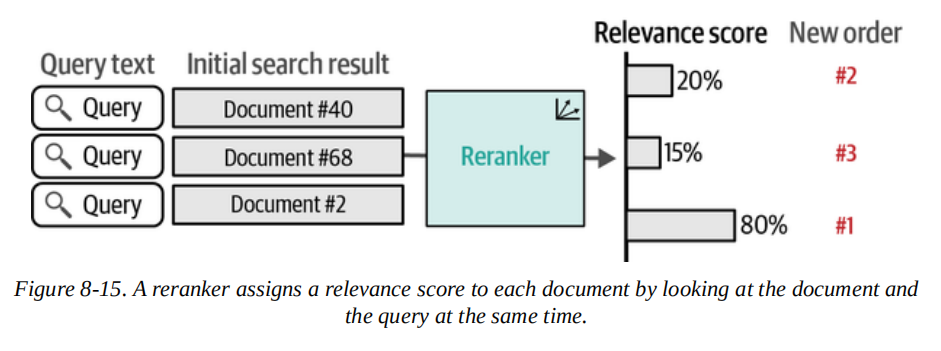

图8-15。重排器通过同时查看文档和查询，为每个文档分配一个相关性得分。

将搜索表述为相关性评分基本上可以归结为一个分类问题。给定这些输入，模型输出一个从0到1的分数，其中0表示不相关，1表示高度相关。这应该与我们在第4章的分类讨论中的内容很熟悉。

要了解更多关于使用大型语言模型（LLM）进行搜索的开发信息，强烈推荐阅读“用于文本检索的预训练变换器：BERT及其超越”，这篇文章回顾了这些模型直到大约2021年的发展。

# 检索评估指标

语义搜索是使用信息检索（IR）领域的指标进行评估的。让我们讨论其中一种流行的指标：平均精度均值（MAP）。  
评估搜索系统需要三个主要组成部分：一个文本档案、一组查询以及指示每个查询的相关文档的相关性判断。我们在图8-16中看到了这些组成部分。

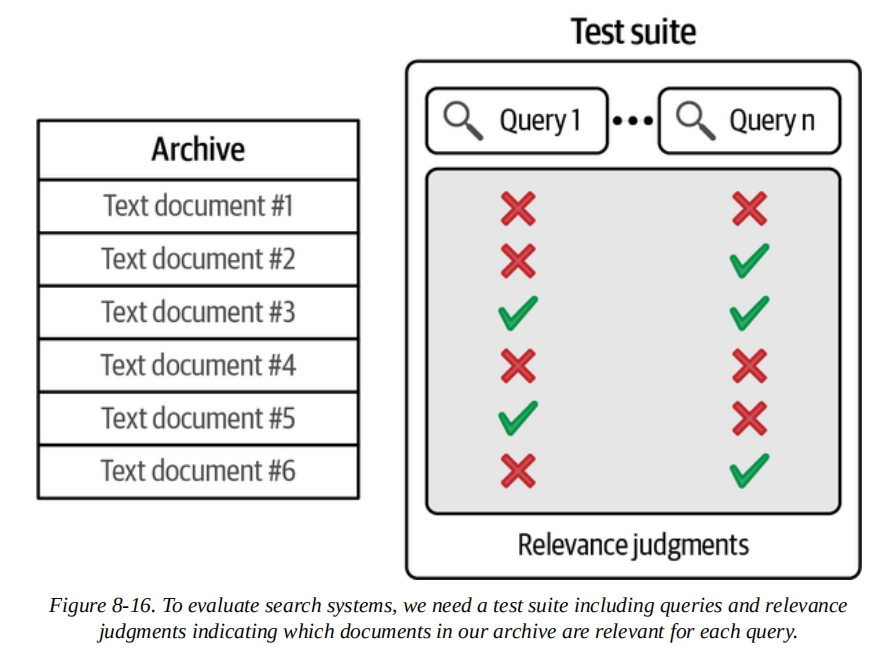

图8-16。为了评估搜索系统，我们需要一个测试套件，包括查询和相关性判断，以指示我们档案中的哪些文档与每个查询相关。

使用这个测试套件，我们可以开始探索评估搜索系统。让我们从一个简单的例子开始。假设我们将查询1传递给两个不同的搜索系统，并得到两组结果。假设我们将结果数量限制为三个，正如我们在图8-17中看到的。

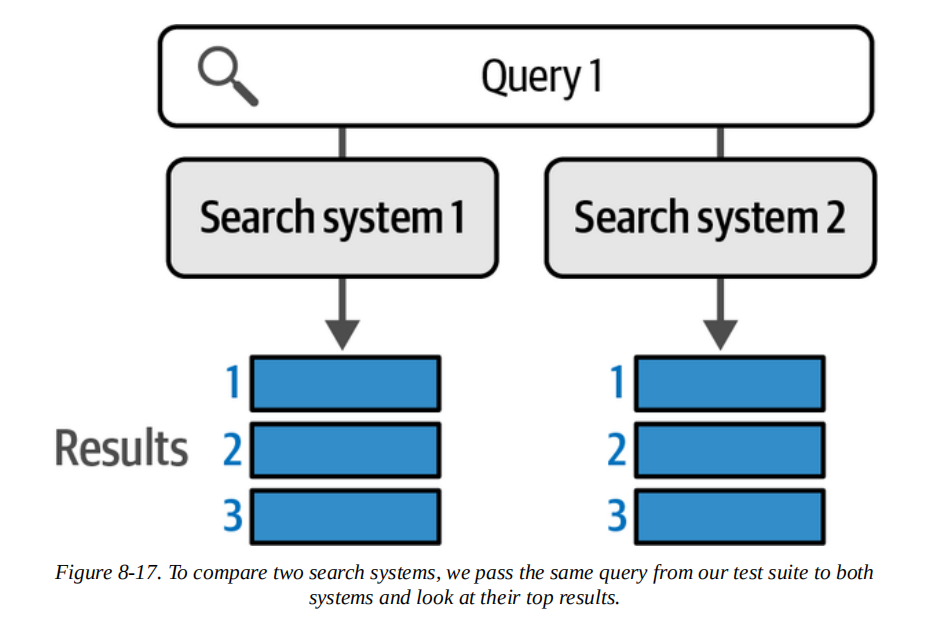

图8-17。为了比较两个搜索系统，我们将测试套件中的同一个查询传递给这两个系统，并查看它们的顶部结果。

为了判断哪个系统更好，我们参考我们对查询的相关性判断。图8-18显示了返回结果中哪些是相关的。

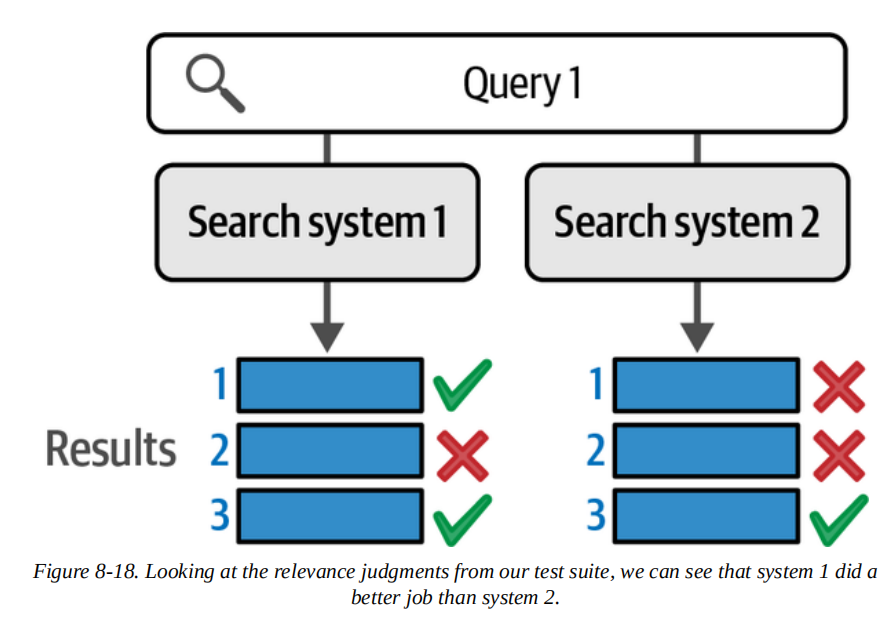

图8-18。通过查看我们的测试套件中的相关性判断，我们可以看到系统1比系统2做得更好。

这清楚地向我们展示了系统1比系统2更好。
直观上，我们可能只是计算每个系统检索到的相关结果数量。系统1在三个结果中有两个是正确的，而系统2在三个结果中只有一个是正确的。但是在图8-19这样的情况怎么办，两个系统都只从三个结果中检索出一个相关结果，但它们的位置不同？

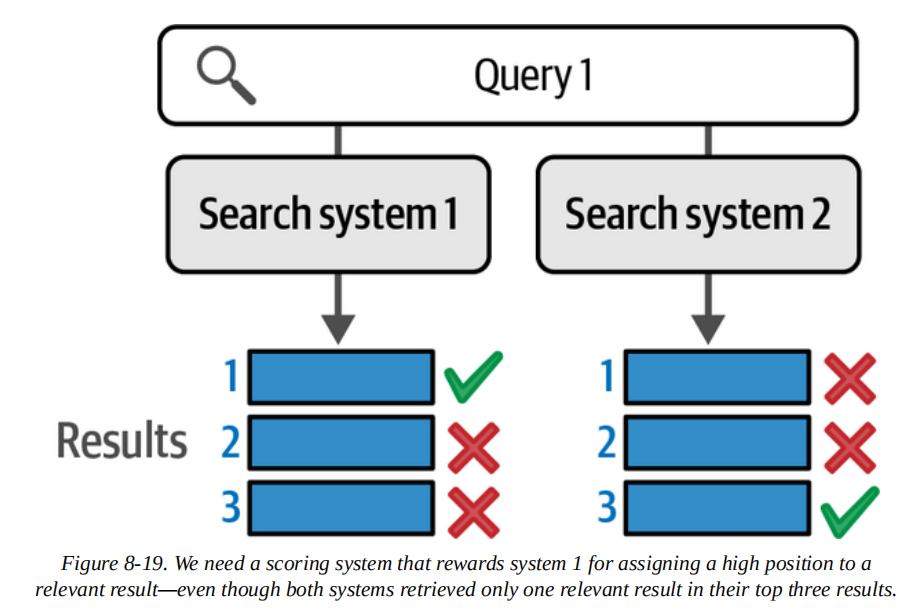

图8-19。我们需要一个评分系统，它能够奖励系统1为相关结果分配了高位置——尽管两个系统在其前三名结果中只检索出了一个相关结果。

在这种情况下，我们可以直观地认为系统1比系统2做得更好，因为第一个位置（最重要的位置）的结果是正确的。但是我们如何给这个结果分配一个数字或分数来衡量它好了多少呢？平均精度均值（MAP）是一种能够量化这种差异的度量方法。

在这种情况下，给定场景分配数字分数的一个常见方法是平均精度，它评估系统1对查询的结果为1，而系统2的为0.3。那么让我们看看如何计算平均精度来评估一组结果，然后如何将其聚合以评估测试套件中所有查询的系统。

# 使用平均精度对单个查询进行评分

为了对搜索系统在这个查询上的得分进行评分，我们可以专注于对相关文档进行评分。让我们从一个测试套件中只有一个相关文档的查询开始。

第一个情况很简单：搜索系统将相关结果（这个查询唯一可用的结果）放在了顶部。这为系统获得了完美的1分。图8-20显示了这个计算：在第一个位置，我们有一个相关结果，导致在位置1的精确度为1.0（计算为位置1的相关结果数量除以我们当前查看的位置）。

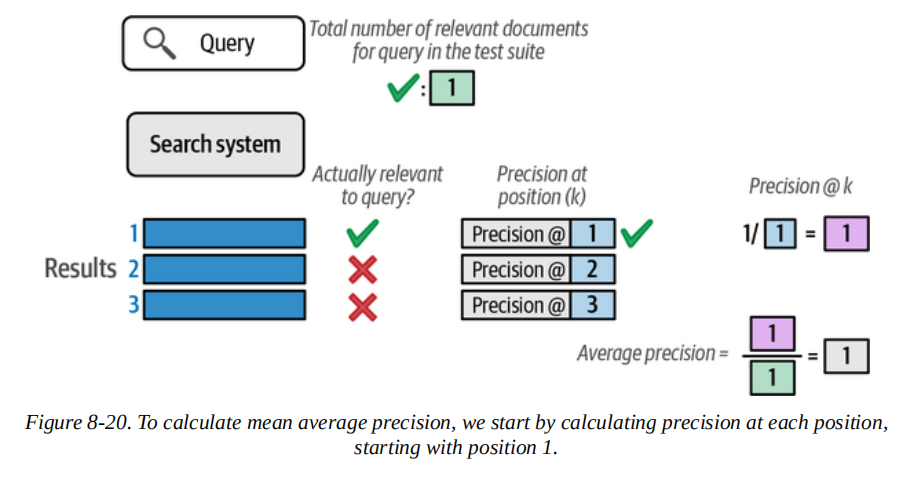

图8-20。要计算平均精度均值，我们首先从位置1开始计算每个位置的精确度。

由于我们只对相关文档进行评分，我们可以忽略不相关文档的分数，并在这里停止计算。然而，如果系统实际上将唯一的相关结果放在了第三位，那会怎么样呢？这将如何影响分数？图8-21展示了这会导致惩罚。

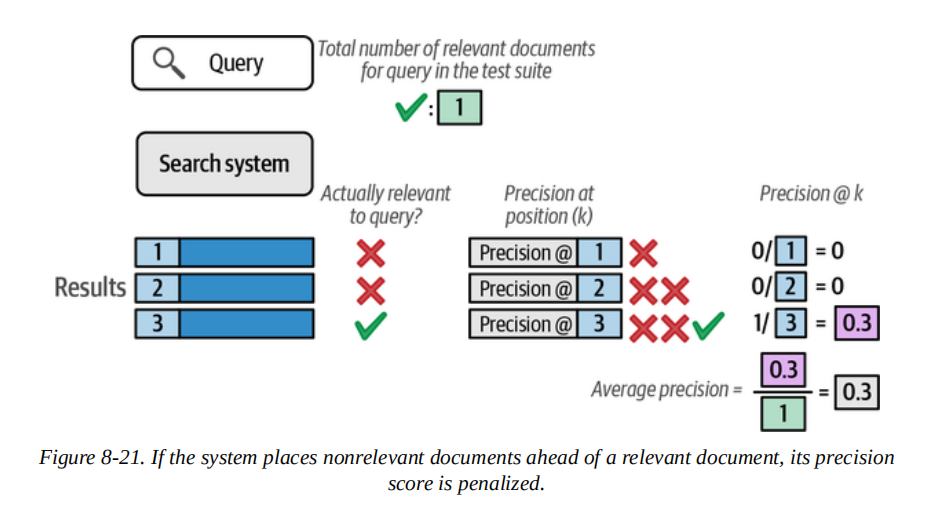

图8-21。如果系统将不相关的文档放在相关文档之前，其精确度分数会受到惩罚。

现在让我们来看一个有多个相关文档的查询。图8-22展示了计算过程，以及如何将平均值纳入考量。

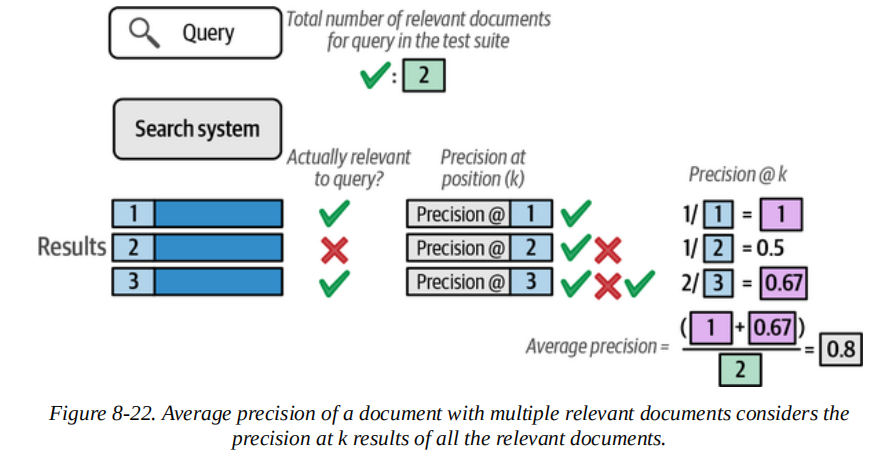

图8-22。对于有多个相关文档的文档，平均精度考虑了所有相关文档在k个结果中的精确度。

# 使用平均精度均值对多个查询进行评分

现在我们已经熟悉了k位置的精确度和平均精度，我们可以将这些知识扩展到一个可以对测试套件中的所有查询进行评分的度量标准上。这个度量标准被称为平均精度均值（MAP）。图8-23展示了如何通过计算每个查询的平均精度的平均值来计算这个度量标准。

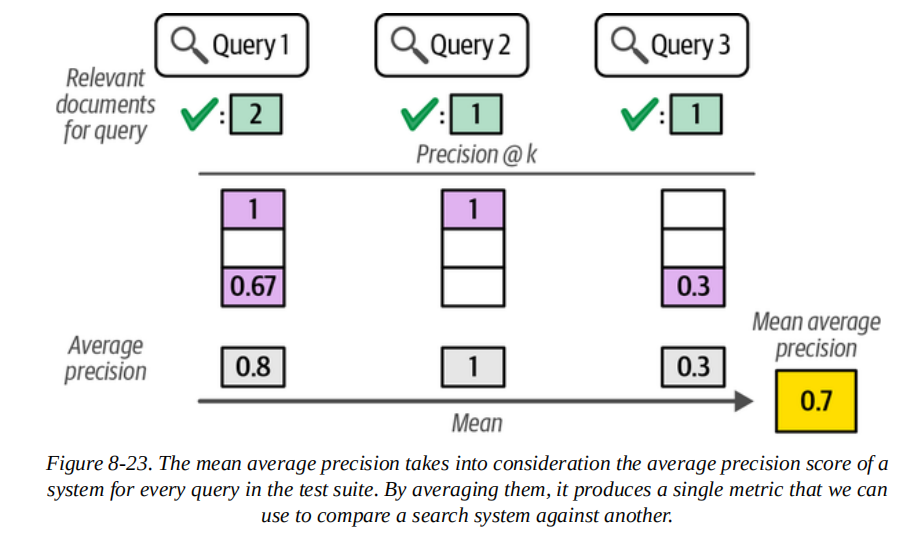

图8-23。平均精度均值考虑了系统在测试套件中每个查询的平均精度得分。通过对它们进行平均，它产生了一个单一的度量标准，我们可以用它来比较一个搜索系统与另一个搜索系统。

你可能想知道为什么相同的操作被称为“mean”和“average”。这很可能是一个审美选择，因为MAP听起来比average average precision更好。

现在我们有一个单一的度量标准，可以用来比较不同的系统。如果你想了解更多关于评估指标的信息，请参阅Christopher D. Manning、Prabhakar Raghavan和Hinrich Schütze所著的《Introduction to Information Retrieval》（剑桥大学出版社）中的“Evaluation in Information Retrieval”章节。

除了平均精度均值，另一个常用于搜索系统的度量标准是归一化折扣累积增益（nDCG），它更加细致，因为文档的相关性不是二元的（相关与不相关），在测试套件和评分机制中，一个文档可以被标记为比另一个文档更相关。

# Retrieval-Augmented Generation
#   检索增强生成

大型语言模型（LLMs）的大规模采用很快导致人们向它们提问并期待得到事实性的答案。虽然这些模型可以正确回答一些问题，但它们也自信地错误回答了很多问题。业界为了纠正这种行为而转向的主要方法是RAG，该方法在论文“Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks”（2020）1中有所描述，并在图8-24中进行了说明。

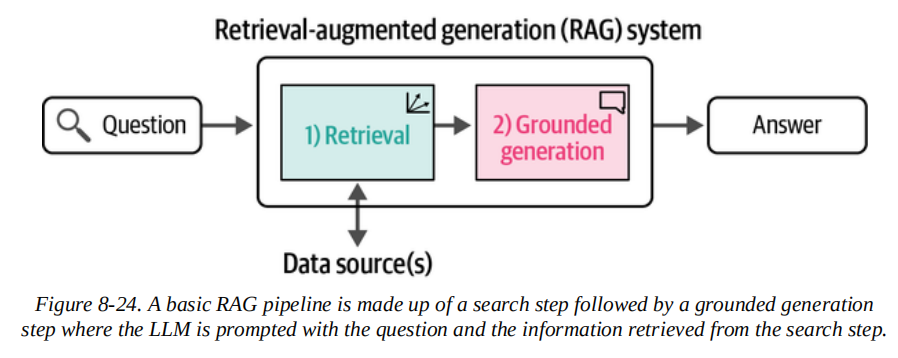

图8-24。一个基本的RAG流程由一个搜索步骤和一个有根据的生成步骤组成，其中大型语言模型（LLM）会被提示问题和从搜索步骤检索到的信息。

RAG系统除了生成能力外，还整合了搜索能力。它们可以被视为对生成系统的改进，因为它们减少了幻觉并提高了事实性。它们还使得“与我的数据聊天”这样的用例成为可能，消费者和公司可以使用这些用例将大型语言模型（LLM）应用于内部公司数据，或特定感兴趣的数据源（例如，与一本书聊天）。

这也扩展到了搜索系统。越来越多的搜索引擎正在整合LLM来总结结果或回答提交给搜索引擎的问题。例子包括Perplexity、Microsoft Bing AI和Google Gemini。

# 从搜索到RAG

现在让我们将搜索系统转变为RAG系统。我们通过在搜索流程的末尾添加一个大型语言模型（LLM）来实现这一点。我们将问题和检索到的顶部文档呈现给LLM，并要求它根据搜索结果提供的上下文来回答问题。我们可以在图8-25中看到一个示例。

这个生成步骤被称为有根据的生成，因为我们提供给LLM的相关信息建立了一个特定的上下文，使LLM扎根于我们感兴趣的领域。图8-26展示了如果我们继续之前的嵌入搜索示例，有根据的生成如何适应搜索之后的步骤。

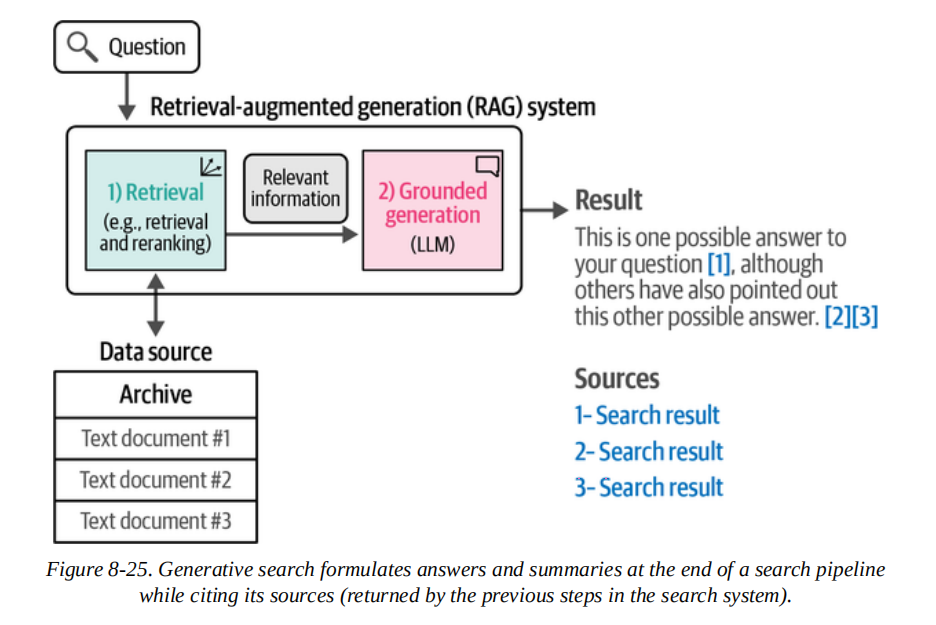

图8-25。生成性搜索在搜索流程的末端制定答案和摘要，同时引用其来源（由搜索系统前几步返回的结果）。

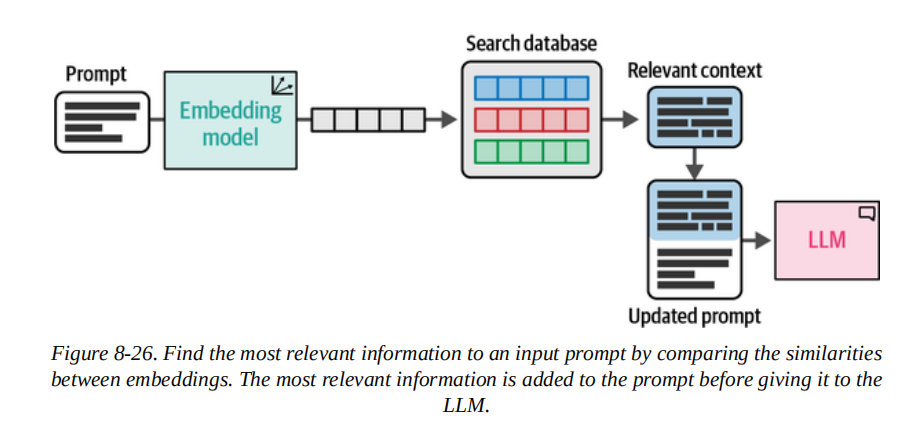

图8-26。通过比较嵌入之间的相似性，找到与输入提示最相关的信息。在将最相关的信息添加到提示中之后，再将其提供给大型语言模型（LLM）。

## Example: Grounded Generation with an LLM API


让我们看看如何在搜索结果之后添加一个有根据的生成步骤来创建我们的第一个RAG系统。在这个例子中，我们将使用Cohere的管理型LLM，它建立在我们之前在本章中见过的搜索系统之上。我们将使用嵌入搜索来检索顶部文档，然后将这些文档连同问题一起传递给co.chat端点，以提供一个有根据的答案：

In [18]:
query = "income generated"

# 1- Retrieval
# We'll use embedding search. But ideally we'd do hybrid
results = search(query)

# 2- Grounded Generation
docs_dict = [{'text': text} for text in results['texts']]
response = co.chat(
    message = query,
    documents=docs_dict
)

print(response.text)

Query:'income generated'
Nearest neighbors:
The film had a worldwide gross of over $677 million, and $773 million with subsequent re-releases.


In [19]:
response

NonStreamedChatResponse(text='The film had a worldwide gross of over $677 million, and $773 million with subsequent re-releases.', generation_id='ceaef6bd-bde1-4c20-b118-c3abc5685df7', citations=[ChatCitation(start=15, end=51, text='worldwide gross of over $677 million', document_ids=['doc_0']), ChatCitation(start=57, end=98, text='$773 million with subsequent re-releases.', document_ids=['doc_0'])], documents=[{'id': 'doc_0', 'text': 'The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014'}], is_search_required=None, search_queries=None, search_results=None, finish_reason='COMPLETE', tool_calls=None, chat_history=[Message_User(message='income generated', tool_calls=None, role='USER'), Message_Chatbot(message='The film had a worldwide gross of over $677 million, and $773 million with subsequent re-releases.', tool_calls=None, role='CHATBOT')], prompt=None, meta=ApiMeta(api_version=ApiMetaApiVers

In [20]:
pd.DataFrame(response)

0                                                  1
0                 text  The film had a worldwide gross of over $677 mi...
1        generation_id               ceaef6bd-bde1-4c20-b118-c3abc5685df7
2            citations  [start=15 end=51 text='worldwide gross of over...
3            documents  [{'id': 'doc_0', 'text': 'The film had a world...
4   is_search_required                                               None
5       search_queries                                               None
6       search_results                                               None
7        finish_reason                                           COMPLETE
8           tool_calls                                               None
9         chat_history  [message='income generated' tool_calls=None ro...
10              prompt                                               None
11                meta  api_version=ApiMetaApiVersion(version='1', is_...
12         response_id               9bee6009-645e-418c-81c6-0ee5fb57627a

根据提供的信息，这是一个非流式聊天响应（NonStreamedChatResponse），它包含了以下关键信息：

1. 文本内容：电影全球票房超过6.77亿美元，随后的重映使其总票房达到7.73亿美元。

2. 引用信息：这个数字来源于一个引用，该引用摘自文档ID为'doc_0'的内容，具体文本为“grossed over $677 million worldwide, and $773 million with subsequent re-releases.”。

3. 文档信息：提供了一个文档，ID为'doc_0'，文本内容为“The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014”，说明这部电影是2014年全球票房第十高的电影。

4. 聊天历史：包含了用户和聊天机器人之间的消息交换，用户询问了“income generated”，机器人回答了关于电影票房的信息。

5. 元数据：提供了API版本、计费单位、输入和输出的令牌数等技术细节。

6. 完成状态：响应的完成原因是“COMPLETE”，表示这个聊天响应已经完成。

7. 相应ID：'8cf5b031-92dc-44e5-b303-407fa157b9c0'。

总结来说，这个聊天响应提供了关于一部电影票房收入的信息，包括全球票房和重映后的总票房，以及这个信息的来源文档。同时，它还记录了用户和机器人之间的交互历史，并包含了一些技术元数据。

我们正在突出显示一些文本，因为模型指出这些文本片段的来源是我们传入的第一份文档：

In [21]:
response.citations

[ChatCitation(start=15, end=51, text='worldwide gross of over $677 million', document_ids=['doc_0']),
 ChatCitation(start=57, end=98, text='$773 million with subsequent re-releases.', document_ids=['doc_0'])]

## Example: RAG with Local Models


现在让我们用本地模型复制这个基本功能。我们将失去进行跨度引用的能力，而且较小的本地模型也不会像较大的托管模型那样工作得好，但这对于展示流程是有用的。我们将从下载一个量化模型开始。

### Loading the Generation Model


In [22]:
!wget https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf/resolve/main/Phi-3-mini-4k-instruct-fp16.gguf

--2024-12-12 03:52:49--  https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf/resolve/main/Phi-3-mini-4k-instruct-fp16.gguf
Resolving huggingface.co (huggingface.co)... 65.8.243.16, 65.8.243.92, 65.8.243.46, ...
Connecting to huggingface.co (huggingface.co)|65.8.243.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/41/c8/41c860f65b01de5dc4c68b00d84cead799d3e7c48e38ee749f4c6057776e2e9e/5d99003e395775659b0dde3f941d88ff378b2837a8dc3a2ea94222ab1420fad3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Phi-3-mini-4k-instruct-fp16.gguf%3B+filename%3D%22Phi-3-mini-4k-instruct-fp16.gguf%22%3B&Expires=1734234769&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNDIzNDc2OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzQxL2M4LzQxYzg2MGY2NWIwMWRlNWRjNGM2OGIwMGQ4NGNlYWQ3OTlkM2U3YzQ4ZTM4ZWU3NDlmNGM2MDU3Nzc2ZTJlOWUvNWQ5OTAwM2UzOTU3NzU2NTliMGRkZTNmOTQxZDg4ZmYzN

In [33]:
pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 MB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.5-cp310-cp310-linux_x86_64.whl size=3471464 sha256=516d44552e1057cb092a5c46df817d0decc9d4dd8b95a747be5bbfca1a0fa153
  Stored in directory: /root/.cache/pip/wheels/7e/ae/c3/34a10eba5fc4e75df17818312b6a1ee29eb90f13a12c524714
Successfully built llama-cpp-python


In [40]:
from langchain import LlamaCpp

# Make sure the model path is correct for your system!
llm = LlamaCpp(
    model_path="Phi-3-mini-4k-instruct-fp16.gguf",
    n_gpu_layers=-1,
    max_tokens=500,
    n_ctx=2048,
    seed=42,
    verbose=False#是否打印详细的调试信息
)

llama_new_context_with_model: n_batch is less than GGML_KQ_MASK_PAD - increasing to 32
llama_new_context_with_model: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized


### Loading the Embedding Model

现在让我们加载一个嵌入语言模型。在这个例子中，我们选择BAAI/bge-small-en-v1.5模型。在撰写本文时，它在MTEB排行榜上的嵌入模型中排名很高，且相对较小：

In [41]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# Embedding Model for converting text to numerical representations
embedding_model = HuggingFaceEmbeddings(
    model_name='thenlper/gte-small'
)

### Preparing the Vector Database

In [42]:
from langchain.vectorstores import FAISS

# Create a local vector database
db = FAISS.from_texts(texts, embedding_model)

### The RAG Prompt


在RAG流程中，提示模板扮演着至关重要的角色。它是我们向LLM传达相关文档的核心地点。为此，我们将创建一个名为context的额外输入变量，它可以为LLM提供检索到的文档：

In [43]:
from langchain import PromptTemplate
from langchain.chains import RetrievalQA


# Create a prompt template
template = """<|user|>
Relevant information:
{context}

Provide a concise answer the following question using the relevant information provided above:
{question}<|end|>
<|assistant|>"""
prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

# RAG Pipeline
rag = RetrievalQA.from_chain_type(#创建了一个 RetrievalQA 实例，用于构建检索式问答系统
    llm=llm,#Phi-3-mini-4k-instruct-fp16
    chain_type='stuff',#它将检索到的文档内容填充到提示模板中
    retriever=db.as_retriever(),
    chain_type_kwargs={
        "prompt": prompt
    },
    verbose=True
)

In [ ]:
rag.invoke('Income generated')



> Entering new RetrievalQA chain...


In [ ]:
{
'query': '产生的收入',
'result': '《星际穿越》在2014年全球票房收入超过6.77亿美元，并且通过随后的重新上映获得了额外的收入，总计大约7.73亿美元。该电影的发行利用了传统的胶片和数字放映机在不同的场所放映，以最大化其收入生成潜力。'
}

# 高级RAG技术
有许多额外的技术可以提高RAG系统的性能。以下是其中的一些。

1. 查询重写   
如果RAG系统是一个聊天机器人，前面的简单RAG实现可能在搜索步骤中会遇到困难，如果问题是过于冗长，或者需要引用对话中之前消息的上下文。这就是为什么使用LLM重写查询是一个好主意，将其改写为有助于检索步骤获取正确信息的查询。一个例子是这样的消息：  
用户问题：“我们明天有一篇论文要交。我们必须写关于某种动物的。我喜欢企鹅。我可以写关于它们的。但我也可以写关于海豚的。它们是动物吗？也许吧。我们来写海豚吧。它们住在哪里，例如？”  
这实际上应该被重写为：  
查询：“海豚住在哪里”  
这种重写行为可以通过提示（或通过API调用）来完成。例如，Cohere的API有一个专门的查询重写模式用于co.chat。

2. 多查询RAG  
我们可以引入的下一个改进是扩展查询重写，如果需要多个查询来回答一个特定问题，就搜索多个查询。例如：  
用户问题：“比较Nvidia在2020年和2023年的财务结果”  
我们可能会找到一个包含两年结果的文档，但更有可能的是，我们最好进行两个搜索查询：  
查询1：“Nvidia 2020年财务结果”  
查询2：“Nvidia 2023年财务结果”  
然后我们将两个查询的顶部结果呈现给模型，进行有根据的生成。这里的一个小改进是，也给查询重写器一个选项，以确定是否不需要搜索，如果它可以直接生成一个自信的答案而不进行搜索。

3. 多跳RAG  
一个更高级的问题可能需要一系列顺序查询。例如一个问题：  
用户问题：“2023年最大的汽车制造商是谁？它们是否各自生产电动汽车？”  
为了回答这个问题，系统必须首先搜索：  
步骤1，查询1：“2023年最大的汽车制造商”  
然后，在获得这些信息（结果是丰田、大众和现代）之后，它应该提出后续问题：  
步骤2，查询1：“丰田汽车公司电动汽车”  
步骤2，查询2：“大众汽车公司电动汽车”  
步骤2，查询3：“现代汽车公司电动汽车”  

4. 查询路由  
另一个增强功能是给模型提供搜索多个数据源的能力。例如，我们可以为模型指定，如果它收到关于人力资源的问题，它应该搜索公司的人力资源信息系统（例如，Notion），但如果问题是关于客户数据，那么它应该搜索客户关系管理（CRM）（例如，Salesforce）。  

5. Agentic RAG  
你现在可能可以看到，前面的增强功能列表慢慢地将越来越多的责任委托给LLM来解决越来越复杂的问题。这依赖于LLM评估所需信息需求的能力以及利用多个数据源的能力。LLM的这种新特性开始越来越接近于在世界上采取行动的代理。数据源现在也可以被抽象成工具。我们看到，例如，我们可以搜索Notion，但同样，我们应该也能够发布到Notion。  

并非所有的LLM都具备这里提到的RAG能力。在撰写本文时，可能只有最大的托管模型才可能尝试这种行为。幸运的是，Cohere的Command R+在这些任务上表现出色，并且也可以作为开放权重模型使用。  

# RAG评估
如何评估RAG模型仍在不断发展中。关于这个话题，有一篇好论文值得一读：“评估生成性搜索引擎的可验证性”（2023年），它对不同的生成性搜索系统进行了人类评估。2
它沿着四个轴评估结果：
1. 流畅性  
 生成的文本是否流畅且连贯。
2. 感知效用  
生成的答案是否有帮助且信息丰富。
3. 引用召回  
关于外部世界的生成陈述中完全由其引用支持的比例。
4. 引用精确度  
生成的引用支持其关联陈述的比例。  
虽然人类评估总是首选，但也有尝试通过让一个有能力的LLM充当裁判（称为LLM-as-a-judge）来自动化这些评估的方法，并在不同的轴上对不同的生成进行评分。Ragas就是这样的一个软件库。它还评分一些额外有用的指标，如：
- 忠实度
答案是否与提供的上下文一致
- 答案相关性
答案与问题的相关性   
[Ragas文档网站](https://oreil.ly/Diugy)提供了更多关于如何计算这些指标的公式细节。


在这一章中，我们探讨了使用语言模型来改进现有搜索系统以及成为新的、更强大的搜索系统核心的不同方法。这些包括：

- 密集检索，它依赖于文本嵌入的相似性。这些系统将搜索查询嵌入，并检索与查询嵌入最接近的文档。
- 重排器，系统（如monoBERT）会查看查询和候选结果，并对每个文档与该查询的相关性进行评分。然后使用这些相关性分数根据它们与查询的相关性对入围结果进行排序，通常会产生改进后的结果排名。
- RAG，在管道的末端有一个生成性的大型语言模型（LLM），它可以根据检索到的文档制定答案，同时引用来源。 我们还探讨了评估搜索系统的一种可能方法。平均精度均值（MAP）使我们能够对搜索系统进行评分，以便能够在一系列测试查询及其已知的相关性上进行比较。然而，评估RAG系统需要多个维度，如忠实度、流畅度等，这些可以通过人类或LLM-as-a-judge进行评估。  

在下一章中，我们将探索如何使语言模型变为多模态，并不仅仅关于文本，还能推理图像。